In [1]:
# Importing basic libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from numpy import zeros, newaxis
from pathlib import Path
from collections import OrderedDict

# fix random seed for reproducibility
SEED = 101
np.random.seed(SEED)
tf.random.set_seed(SEED)
               
# Importing the training set
DATA_DIR = Path("../input/stanford-covid-vaccine/")
BPPS_DIR = DATA_DIR / "bpps"

train = pd.read_json(DATA_DIR / "train.json", lines=True)
test = pd.read_json(DATA_DIR / "test.json", lines=True)
aug_df = pd.read_csv('/kaggle/input/how-to-generate-augmentation-data/aug_data.csv')

bppm_paths = list(BPPS_DIR.glob("*.npy"))

#settings
debug = False
TPU = False

In [2]:
# Light data exploration, to check features lengths
len(train['sequence'][0]), len(train['structure'][0]), len(train['predicted_loop_type'][0])

(107, 107, 107)

In [3]:
# Examine features
train['sequence'][60], train['structure'][60] ,train['predicted_loop_type'][60]

('GGAAAGACUACGAGUGUCGUGUUUACCUAACGAGAUAGAAUCGAAGGAUGGCGACGUUCGUAGUCGGACUUAGUUUUCGAACUAAGAAAAGAAACAACAACAACAAC',
 '.....(((((((((((((((.....(((..(((.......))).)))...)))))))))))))))...(((((((....))))))).....................',
 'EEEEESSSSSSSSSSSSSSSIIIIISSSIISSSHHHHHHHSSSISSSIIISSSSSSSSSSSSSSSXXXSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE')

In [4]:
# Data Processing
# Set alphabets
alphabet = 'AGCU().MXBISHE'
alphabet_rna = 'AGCU'
alphabet_struc = '()XXX.'
alphabet_loop = 'MXB...I...S.H.E'

# Set target_cols
target_cols  = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
non_target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
marked_target_cols  = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']

def get_bppm(id_):
    return np.load(BPPS_DIR / f"{id_}.npy")

def get_bpps_nb(id_):
     # from https://www.kaggle.com/symyksr/openvaccine-deepergcn 
    bpps_nb_mean = 0.077522 # mean of bpps_nb across all training data
    bpps_nb_std = 0.08914   # std of bpps_nb across all training data
    bpps = get_bppm(id_)
    bpps_nb = (bpps > 0).sum(axis=0) / bpps.shape[0]
    bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
    return bpps_nb

def mk_pair_map(structure, type='pm'):
    pm = np.full(len(structure), 0, dtype=int)
    pd = np.full(len(structure), 0, dtype=int)
    queue = []
    for i, s in enumerate(structure):
        if s == "(":
            queue.append(i)
            #print("Found '(' at i={}, queue={}".format(i, queue))
        elif s == ")":
            j = queue.pop()
            pm[i] = j
            pm[j] = i
            pd[i] = i-j
            pd[j] = i-j
            #print("Found ')' at i={}, j={}, queue={}, pd[i]={}, pd[j]={}, i-j={}".format(i, j, queue, pd[i], pd[j], i-j))
    if type == 'pm':
        return pm
    elif type == 'pd':
        return pd    
    
def get_structure_adj(seq_length, structure, sequence):
    Ss = []
    cue = []
    a_structures = OrderedDict([
        (("A", "U"), np.zeros([seq_length, seq_length])),
        (("C", "G"), np.zeros([seq_length, seq_length])),
        (("U", "G"), np.zeros([seq_length, seq_length])),
        (("U", "A"), np.zeros([seq_length, seq_length])),
        (("G", "C"), np.zeros([seq_length, seq_length])),
        (("G", "U"), np.zeros([seq_length, seq_length])),
    ])
    for j in range(seq_length):
        if structure[j] == "(":
            cue.append(j)
        elif structure[j] == ")":
            start = cue.pop()
            a_structures[(sequence[start], sequence[j])][start, j] = 1
            a_structures[(sequence[j], sequence[start])][j, start] = 1

    a_strc = np.stack([a for a in a_structures.values()], axis=2)
    a_strc = np.sum(a_strc, axis=2, keepdims=False)
    return a_strc

def preprocess_data(data):
    data = data.loc[data['SN_filter'] == 1].copy()
    data = data.reset_index(drop=True)
    return data

def step(seq_length):
    data = list(range(int(seq_length)))
    newList = []
    newList = [x / seq_length for x in data]
    return newList

def preprocess_features(data):
    data['seq'] = data.apply(lambda x: integer_encoder(x['sequence'], alphabet_rna), axis=1)
    data['struc'] = data.apply(lambda x: integer_encoder(x['structure'], alphabet_struc), axis=1)
    data['loop'] = data.apply(lambda x: integer_encoder(x['predicted_loop_type'], alphabet_loop), axis=1)
    data['step'] = data.apply(lambda x: step(x['seq_length']), axis=1) # Doesn't help
    data['pair_dist'] = data.structure.apply(mk_pair_map, type='pd') # Not sure it helps
    data['pair_map'] = data.structure.apply(mk_pair_map, type='pm') # Not sure it helps
    data['bppm_max'] = data.apply(lambda x: get_bppm(x['id']).max(0), axis=1)
    data['bppm_sum'] = data.apply(lambda x: get_bppm(x['id']).sum(0), axis=1)
    data['bppm_nb'] = data.apply(lambda x: get_bpps_nb(x['id']), axis=1)
    data['adj_struc'] = data.apply(lambda x: get_structure_adj(x['seq_length'], x['structure'], x['sequence']).sum(0), axis=1)
    a = np.array(data['seq'].values.tolist())[:,:,newaxis]
    b = np.array(data['struc'].values.tolist())[:,:,newaxis]
    c = np.array(data['loop'].values.tolist())[:,:,newaxis]
    d = np.array(data['adj_struc'].values.tolist())[:,:,newaxis]
    f = np.array(data['bppm_max'].values.tolist())[:,:,newaxis]
    g = np.array(data['bppm_sum'].values.tolist())[:,:,newaxis]
    h = np.array(data['bppm_nb'].values.tolist())[:,:,newaxis] 
    features_all=np.concatenate((a,b,c,d,f,g,h), axis = 2) 
    return features_all

def preprocess_labels(data):
    labels = data[target_cols].copy()
    return np.array(labels.values.tolist())

def integer_encoder(my_string, alphabet):
    data = my_string.lower()
    alphabet = alphabet.lower()
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    # integer encode input data
    integer_encoded = [char_to_int[char] for char in data]
        
    return np.array(integer_encoded)

def one_hot_encoder(my_string, alphabet):
    data = my_string.lower()
    alphabet = alphabet.lower()
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    # integer encode input data
    integer_encoded = [char_to_int[char] for char in data]
    
    onehot_encoded = list()
    
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))]
        letter[value] = 1
        onehot_encoded.append(letter)
        
    return np.array(onehot_encoded)

def one_hot_encoder_int(integer_encoded):    
    onehot_encoded = list()
    
    for value in integer_encoded:
        letter = [0 for _ in range(-1,90)]
        letter[value] = 1
        onehot_encoded.append(letter)
        
    return np.array(onehot_encoded)

In [5]:
# Examine features
train['sequence'][0], train['structure'][0] ,train['predicted_loop_type'][0]

('GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC',
 '.....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................',
 'EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHHHSSSSSSIISSIIIIISSXXXXSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE')

In [6]:
def aug_data(df):
    target_df = df.copy()
    new_df = aug_df[aug_df['id'].isin(target_df['id'])]
                         
    del target_df['structure']
    del target_df['predicted_loop_type']
    new_df = new_df.merge(target_df, on=['id','sequence'], how='left')

    df['cnt'] = df['id'].map(new_df[['id','cnt']].set_index('id').to_dict()['cnt'])
    df['log_gamma'] = 100
    df['score'] = 1.0
    df = df.append(new_df[df.columns])
    return df
train = aug_data(train)
test = aug_data(test)

In [7]:
# Prepare features
train_features = preprocess_features(preprocess_data(train))

# Prepare labels data
train_labels = preprocess_labels(preprocess_data(train)).transpose(0,2,1)

In [8]:
train_features.shape, train_labels.shape

((4653, 107, 7), (4653, 68, 5))

In [9]:
def plot_structures(features: np.ndarray, labels: np.ndarray):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(features.T)
    axes[0].set_title("Features")
    axes[1].imshow(labels.T)
    axes[1].set_title("Labels")
    plt.show()

In [10]:
# Examine features
train['sequence'][2], train['structure'][2] ,train['predicted_loop_type'][2]

(2    GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...
 2    GGAAAAAGGUUGGAAUGCAGCAUCAGGAAUACUGAUGUCAAGUAAC...
 Name: sequence, dtype: object,
 2    .....((((.((.....((((.(((.....)))..((((......)...
 2    ................((.(((((((.....)))))))...))......
 Name: structure, dtype: object,
 2    EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...
 2    EEEEEEEEEEEEEEEESSISSSSSSSHHHHHSSSSSSSIIISSMMM...
 Name: predicted_loop_type, dtype: object)

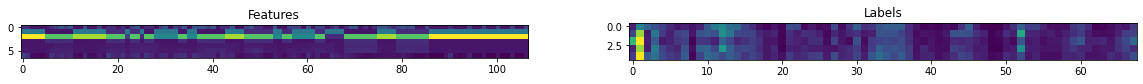

In [11]:
feature = train_features[0:1,:,:]
feature = feature[0,:,:]
labels = train_labels[0:1,:,:]
labels = labels[0,:,:]

plot_structures(feature, labels)

In [12]:
# Importing ML libraries
import keras
import keras.backend as K
import tensorflow as tf
import tensorflow.keras.layers as L

from keras.models import Sequential
from keras.layers import Dropout, Embedding, LSTM, Dense, Bidirectional, Activation, Flatten, GRU
from keras.layers import BatchNormalization, SpatialDropout1D, InputLayer, Reshape, Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.layers.convolutional import Convolution1D, MaxPooling1D


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.cluster import KMeans

In [13]:
# Loss function
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

In [14]:
if TPU:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    # instantiate a distribution strategy
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [15]:
# build model functions
def gru_layer(hidden_dim, dropout):
    return L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer = 'orthogonal'))

def lstm_layer(hidden_dim, dropout):
    return L.Bidirectional(L.LSTM(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer = 'orthogonal'))

def conv1d_layer(filters, kernel_size):
    return L.Conv1D(filters=filters, kernel_size=kernel_size, padding='same')

def max_pool_1d(pool_size, strides):
    return L.MaxPooling1D(pool_size=pool_size, strides=strides, padding='valid')

def build_model(seq_len=107, pred_len=68, dropout1=0.0, dropout2=0.3, embed_dim=230, hidden_dim1=220, hidden_dim2=330, 
                type=0, filters=255, kernel_size=5):
    
    inputs = L.Input(shape=(seq_len, train_features.shape[2]))
    
    # split integer and float features and concatenate them later.
    integer_fea_seq = inputs[:, :, :1]
    embed_seq = L.Embedding(input_dim=len(alphabet_rna)+1, output_dim=embed_dim)(integer_fea_seq)
    reshaped_seq = tf.reshape(embed_seq, shape=(-1, embed_seq.shape[1],  embed_seq.shape[2] * embed_seq.shape[3]))
    conv_seq = conv1d_layer(filters, kernel_size)(reshaped_seq)
    mpool_seq = max_pool_1d(1,1)(conv_seq)
    
    integer_fea_struc = inputs[:, :, 1:2]
    embed_struc = L.Embedding(input_dim=len(alphabet_struc)+1, output_dim=embed_dim)(integer_fea_struc)
    reshaped_struc = tf.reshape(embed_struc, shape=(-1, embed_struc.shape[1],  embed_struc.shape[2] * embed_struc.shape[3]))
    conv_struc = conv1d_layer(filters, kernel_size)(reshaped_struc)
    mpool_struc = max_pool_1d(1,1)(conv_struc)
    
    integer_fea_loop = inputs[:, :, 2:3]
    embed_loop = L.Embedding(input_dim=len(alphabet_loop)+1, output_dim=embed_dim)(integer_fea_loop)
    reshaped_loop = tf.reshape(embed_loop, shape=(-1, embed_loop.shape[1],  embed_loop.shape[2] * embed_loop.shape[3]))
    conv_loop = conv1d_layer(filters, kernel_size)(reshaped_loop)
    mpool_loop = max_pool_1d(1,1)(conv_loop)
    
    float_fea = inputs[:, :, 3:]
    conv_float = conv1d_layer(filters, kernel_size)(float_fea)
    mpool_float = max_pool_1d(1,1)(conv_float)
    concat = L.concatenate([mpool_seq, mpool_struc, mpool_loop, mpool_float], axis=2)

    if type == 0:
        hidden = lstm_layer(hidden_dim1, dropout1)(concat)
        hidden = gru_layer(hidden_dim2, dropout2)(hidden)
    elif type == 1:
        hidden = gru_layer(hidden_dim1, dropout1)(concat)
        hidden = gru_layer(hidden_dim2, dropout2)(hidden)    
    elif type == 2:
        hidden = gru_layer(hidden_dim1, dropout1)(concat)
        hidden = lstm_layer(hidden_dim2, dropout2)(hidden)
    elif type == 3:
        hidden = lstm_layer(hidden_dim1, dropout1)(concat)
        hidden = lstm_layer(hidden_dim2, dropout2)(hidden)
    
    truncated = hidden[:, :pred_len]
    out = L.Dense(5, activation='linear')(truncated)
    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(tf.keras.optimizers.Adam(), loss=MCRMSE)

    return model

In [16]:
if debug:
    train = train[:20]
    test = test[:20]

In [17]:
model = build_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 107, 7)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 107, 1)]     0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 107, 1)]     0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, 107, 1)]     0           input_1[0][0]                    
_______________________________________________________________________________________

In [18]:
if debug:
    n_clusters = 20
else:
    n_clusters = 200

kmeans_model = KMeans(n_clusters=n_clusters, random_state=110).fit(preprocess_features(train)[:,:,2])
train['cluster_id'] = kmeans_model.labels_

In [19]:
def train_and_predict(type = 0, FOLD_N = 5, Ver=1):
    
    if debug:
        FOLD_N = 2
    
    gkf = GroupKFold(n_splits=FOLD_N)

    test_107 = test.query("seq_length == 107").copy()
    test_130  = test.query("seq_length == 130").copy()
    
    inputs_107 = preprocess_features(test_107)
    inputs_130 = preprocess_features(test_130)
        
    holdouts = []
    holdout_preds = []

    for cv, (train_index, test_index) in enumerate(gkf.split(train,  train['deg_Mg_pH10'], train['cluster_id'])):
        
        trn = train.iloc[train_index].copy()
        X_train = preprocess_features(trn)
        y_train = np.array(trn[target_cols].values.tolist()).transpose((0, 2, 1))

        val = train.iloc[test_index].copy()
        x_val_all = preprocess_features(val)
        val = val[val.SN_filter == 1]
        X_test = preprocess_features(val)
        y_test = np.array(val[target_cols].values.tolist()).transpose((0, 2, 1))
        sample_weight = np.log(trn.signal_to_noise+1.1)*2
        
        if TPU:
            with tpu_strategy.scope():
                model = build_model(type=type)
                model_107 = build_model(seq_len=107, pred_len=107,type=type)
                model_130 = build_model(seq_len=130, pred_len=130,type=type)
        else:
            model = build_model(type=type)
            model_107 = build_model(seq_len=107, pred_len=107,type=type)
            model_130 = build_model(seq_len=130, pred_len=130,type=type)

        
        history = model.fit(
            X_train, y_train,
            validation_data = (X_test, y_test),
            batch_size=64,
            epochs=105,
            sample_weight=sample_weight,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(),
                tf.keras.callbacks.ModelCheckpoint(f'model{Ver}_cv{cv}.h5')
            ]
        )
        
        model.load_weights(f'model{Ver}_cv{cv}.h5')
        model_107.load_weights(f'model{Ver}_cv{cv}.h5')
        model_130.load_weights(f'model{Ver}_cv{cv}.h5')
        
        holdouts.append(train.iloc[test_index].copy())
        holdout_preds.append(model.predict(x_val_all))
        
        if cv == 0:
            preds_107 = model_107.predict(inputs_107)/FOLD_N
            preds_130 = model_130.predict(inputs_130)/FOLD_N
        else:
            preds_107 += model_107.predict(inputs_107)/FOLD_N
            preds_130 += model_130.predict(inputs_130)/FOLD_N
    return holdouts, holdout_preds, test_107, preds_107, test_130, preds_130

In [20]:
val_df, val_preds, test_df, test_preds = [], [], [], []

if debug:
    n_model = 1
else:
    n_model = 4

for i in range(n_model):
    holdouts, holdout_preds, test_107, preds_107, test_130, preds_130 = train_and_predict(i)
    val_df += holdouts
    val_preds += holdout_preds
    test_df.append(test_107)
    test_df.append(test_130)
    test_preds.append(preds_107)
    test_preds.append(preds_130)

Epoch 1/105
89/89 [==============================] - 10s 114ms/step - loss: 1.2002 - val_loss: 0.3022
Epoch 2/105
89/89 [==============================] - 9s 96ms/step - loss: 0.9743 - val_loss: 0.2647
Epoch 3/105
89/89 [==============================] - 8s 95ms/step - loss: 0.8831 - val_loss: 0.2469
Epoch 4/105
89/89 [==============================] - 8s 95ms/step - loss: 0.8128 - val_loss: 0.2313
Epoch 5/105
89/89 [==============================] - 8s 95ms/step - loss: 0.7686 - val_loss: 0.2230
Epoch 6/105
89/89 [==============================] - 9s 98ms/step - loss: 0.7366 - val_loss: 0.2136
Epoch 7/105
89/89 [==============================] - 8s 95ms/step - loss: 0.7075 - val_loss: 0.2071
Epoch 8/105
89/89 [==============================] - 8s 95ms/step - loss: 0.6843 - val_loss: 0.2011
Epoch 9/105
89/89 [==============================] - 8s 95ms/step - loss: 0.6628 - val_loss: 0.1960
Epoch 10/105
89/89 [==============================] - 8s 95ms/step - loss: 0.6386 - val_loss: 0.19

In [21]:
preds_ls = []
for df, preds in zip(test_df, test_preds):
    for i, uid in enumerate(df.id):
        single_pred = preds[i]
        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
        preds_ls.append(single_df)
preds_df = pd.concat(preds_ls).groupby('id_seqpos').mean().reset_index()
# .mean() is for
# 1, Predictions from multiple models
# 2, TTA (augmented test data)

preds_ls = []
for df, preds in zip(val_df, val_preds):
    for i, uid in enumerate(df.id):
        single_pred = preds[i]
        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
        single_df['SN_filter'] = df[df['id'] == uid].SN_filter.values[0]
        preds_ls.append(single_df)
holdouts_df = pd.concat(preds_ls).groupby('id_seqpos').mean().reset_index()

In [22]:
submission = preds_df[['id_seqpos', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]
submission.to_csv(f'submission.csv', index=False)
print(f'wrote to submission.csv')

wrote to submission.csv


In [23]:
def print_mse(prd):
    val = pd.read_json('../input/stanford-covid-vaccine/train.json', lines=True)

    val_data = []
    for mol_id in val['id'].unique():
        sample_data = val.loc[val['id'] == mol_id]
        sample_seq_length = sample_data.seq_length.values[0]
        for i in range(68):
            sample_dict = {
                           'id_seqpos' : sample_data['id'].values[0] + '_' + str(i),
                           'reactivity_gt' : sample_data['reactivity'].values[0][i],
                           'deg_Mg_pH10_gt' : sample_data['deg_Mg_pH10'].values[0][i],
                           'deg_Mg_50C_gt' : sample_data['deg_Mg_50C'].values[0][i],
                           }
            val_data.append(sample_dict)
    val_data = pd.DataFrame(val_data)
    val_data = val_data.merge(prd, on='id_seqpos')

    rmses = []
    mses = []
    for col in ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']:
        rmse = ((val_data[col] - val_data[col+'_gt']) ** 2).mean() ** .5
        mse = ((val_data[col] - val_data[col+'_gt']) ** 2).mean()
        rmses.append(rmse)
        mses.append(mse)
        print(col, rmse, mse)
    print(np.mean(rmses), np.mean(mses))

In [24]:
print_mse(holdouts_df)

reactivity 0.5625138297780774 0.31642180869159986
deg_Mg_pH10 0.4775769676403572 0.22807976002055877
deg_Mg_50C 0.6875394911304561 0.4727105518639266
0.5758767628496302 0.33907070685869506


In [25]:
print_mse(holdouts_df[holdouts_df.SN_filter == 1])

reactivity 0.11019492388385661 0.012142921249768953
deg_Mg_pH10 0.13086113690491114 0.017124637152045895
deg_Mg_50C 0.11013107641836341 0.012128853993067401
0.11706237906904371 0.013798804131627415
